In [3]:
function get_motions_orig{N<:AbstractFloat}(forces::Vector{Vector{N}}, strength)

    ndims=length(forces[1] )
    nforces = length(forces)
    motions = [Vector{N}(ndims) for _ in 1:nforces]    
#	[@assert(length(ff)==ndims) for ff in forces]

    for dim in 1:ndims
        north_force = 0.0
        south_force = 0.0
		n_north =0
		n_south =0
        for f_ii in 1:nforces
            force = forces[f_ii][dim]
            if force>0.0
                north_force+=force
				n_north+=1
            else
                south_force+=force
				n_south+=1
            end
        end
        tension = 2*min(north_force,-1*south_force) 
			#This is the resisted force. It that can break, rather than move. 
        if tension>strength*nforces
            for f_ii in 1:nforces
                force = forces[f_ii][dim]
                if force>0.0
                    motions[f_ii][dim] = north_force/n_north 
					#Don't actually decrease distence moved because of force resisted,
					#that is a metaphore.
                else
                    motions[f_ii][dim] = south_force/n_south 
                end
            end 
        else
            #does not break, so all forces apply same motion
            for f_ii in 1:nforces
                motions[f_ii][dim] = (north_force+south_force)/(n_north+n_south) 
            end          
        end
    end

    #Find unique motion rows, and stack up each occurrence.
    #These corespond to all the new points
	counts = Dict{Vector{N},Int64}()
	for motion in motions
		counts[motion]=1 + get!(counts,motion,0)
		#@assert(!(any(isnan(motion))))
	end
	Vector{N}[motion.*count for (motion, count) in counts]
end


get_motions_orig (generic function with 1 method)

In [6]:
using MultivariateStats

INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/StatsBase.ji for module StatsBase.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/ArrayViews.ji for module ArrayViews.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/StatsFuns.ji for module StatsFuns.


In [303]:
@inline function get_directions(forces::Matrix, strength::Number)
    ndims, nforces=size(forces)
    
    directions = [BitVector(ndims) for _ in 1:nforces]
    #False is North split, or nosplit
    
    @inbounds for dim in 1:ndims
        north_force = 0.0
        south_force = 0.0
        @inbounds for f_ii in 1:nforces
            force = forces[dim,f_ii]
            if force>0.0
                north_force+=force
            else
                south_force+=force
            end
        end
        tension = 2*min(north_force,-1*south_force) 
			#This is the resisted force. It that can break, rather than move. 
        if tension>strength*nforces
            @inbounds for f_ii in 1:nforces
                force = forces[dim,f_ii]
                directions[f_ii][dim]=force<0.0
            end 
        end
    end
    directions
end

get_directions (generic function with 1 method)

In [336]:
@fastmath function get_motions_pca{N<:AbstractFloat}(forces::Vector{Vector{N}}, strength::Number, max_red_dims::Integer)
    nforces = length(forces)
    forces_mat = hcat(forces...)
    dim_reducer=fit(PCA, forces_mat,method=:auto, maxoutdim=max_red_dims, mean=0) 
    #Setting the mean as zero, indicated it is already centered, 
    #so PCA will not recenter it, which could change directions
    #if the forces are of very different magnitude eg [1,0f0],[4,0f0], with strength 0.5 results on two forces.
    #TODO: Consider if this is not infact a good thing
    red_forces = transform(dim_reducer, forces_mat)
    @assert(size(red_forces,1)<=64, "reduced dims (=$(red_dims) must be ≤64, so cunning UInt64 can represent all possiblities")
        
    directions = get_directions(red_forces, strength)
    #Find unique motion rows, and stack up each occurrence.
    #These corespond to all the new points
    motions = Dict{BitVector,Vector{N}}()
    @inbounds for f_ii in 1:nforces
        direction = directions[f_ii]#.chunks[1]
        force = forces[f_ii]
        
        if haskey(motions, direction)
            motions[direction]+=force
        else
            motions[direction]=force
        end
    end
    #println(map(bits, keys(motions)))
    collect(values(motions))
end


get_motions_pca (generic function with 2 methods)

In [350]:
@fastmath function get_motions_2{N<:AbstractFloat}(forces::Vector{Vector{N}}, strength::Number)
    nforces = length(forces)
    forces_mat = hcat(forces...)
    
    directions = get_directions(forces_mat, strength)
    #Find unique motion rows, and stack up each occurrence.
    #These corespond to all the new points
    motions = Dict{BitVector,Vector{N}}()
    @inbounds for f_ii in 1:nforces
        direction = directions[f_ii]#.chunks[1]
        force = forces[f_ii]
        
        if haskey(motions, direction)
            motions[direction]+=force
        else
            motions[direction]=force
        end
    end
    #println(map(bits, keys(motions)))
    collect(values(motions))
end


get_motions_2 (generic function with 2 methods)

In [337]:
pending_forces = [randn(30)+2*rand(30) for ii in 1:100];

In [344]:
function tt()
    pending_forces = [randn(30)+2*rand(30) for ii in 1:100];
    for ii in 1:1000
        get_motions_pca(pending_forces, 0.2, 2) |> length
    end
end
gc()
@profile tt()

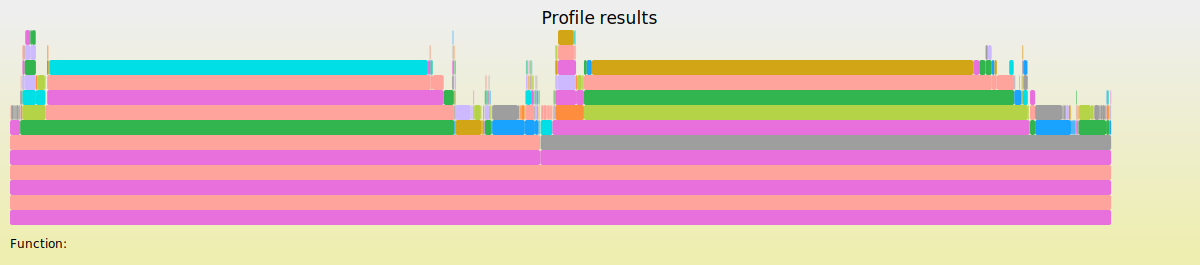

In [345]:
using ProfileView
ProfileView.view()

In [330]:
function tt()
    pending_forces = [randn(30)+2*rand(30) for ii in 1:100];
    for ii in 1:1000
        get_motions_orig(pending_forces, 0.2) |> length
    end
end
gc()
@time tt()

  0.337289 seconds (322.78 k allocations: 75.573 MB, 4.41% gc time)


In [331]:
@time get_motions_pca(pending_forces, 1, 2) |> length

  0.125940 seconds (41.19 k allocations: 1.647 MB)


2

In [359]:
function tt()
    pending_forces = [randn(30)+2*rand(30) for ii in 1:100];
    for ii in 1:1000
        get_motions_2(pending_forces, 0.2)|> length
    end
end
gc()
@time tt()

  0.271855 seconds (332.21 k allocations: 45.881 MB, 5.68% gc time)


In [366]:
function tt()
    pending_forces = [randn(30)+2*rand(30) for ii in 1:100];
    for ii in 1:1000
        @assert get_motions_2(pending_forces, 0.2)|> Set == get_motions_pca(pending_forces, 0.2, 30) |> Set
    end
end
gc()
@time tt()

LoadError: LoadError: AssertionError: get_motions_2(pending_forces,0.2) |> Set == get_motions_pca(pending_forces,0.2,30) |> Set
while loading In[366], in expression starting on line 155

In [356]:
pending_forces = [randn(30)+2*rand(30) for ii in 1:100];
get_motions_2(pending_forces, 0.2)

96-element Array{Array{Float64,1},1}:
 [1.34923,-0.239269,1.10945,0.216338,-0.318241,0.626338,0.155689,2.41897,1.45739,3.66881  …  2.10452,1.39082,0.57874,3.50386,0.117198,0.0476495,1.25511,3.06354,0.245413,1.55965]       
 [2.63376,0.731058,1.37589,0.238004,1.79078,1.24228,0.144674,2.73362,0.211088,0.0761837  …  0.131994,2.16422,2.08294,-0.437729,2.95684,1.85234,4.38122,-0.0798004,-1.62141,0.854443]    
 [1.69852,2.12539,-0.565745,1.20429,1.18681,2.22489,-1.05946,1.50144,3.09896,2.48364  …  -0.203976,1.12345,0.46126,0.289083,2.66228,3.25185,0.293337,3.22948,1.09832,0.666666]          
 [0.97829,0.259086,-0.172864,2.54942,1.43538,0.738951,-0.417598,2.29291,1.81598,1.51196  …  2.66817,1.46759,0.249538,0.911925,0.737521,0.536505,0.772766,0.0337018,-1.89643,-0.0119646] 
 [3.20231,0.161826,0.774593,-0.633972,-0.483768,0.211037,-0.733012,2.42436,-0.652935,-0.576656  …  1.26622,1.2888,1.82685,0.504827,1.04681,2.22053,1.66402,-0.613389,0.398543,0.0766922]
 [2.13914,0.408684,1.11146,1.42716,2.

In [365]:
get_motions_pca(pending_forces, 0.2,30)

100-element Array{Array{Float64,1},1}:
 [0.563254,0.653999,2.04356,0.754703,0.048114,0.887168,2.75154,-0.490871,0.688309,3.42607  …  -0.485608,0.269437,2.85913,0.725473,-0.843453,2.73584,-0.694088,0.472928,1.59855,0.598942] 
 [1.69852,2.12539,-0.565745,1.20429,1.18681,2.22489,-1.05946,1.50144,3.09896,2.48364  …  -0.203976,1.12345,0.46126,0.289083,2.66228,3.25185,0.293337,3.22948,1.09832,0.666666]           
 [2.02381,-0.288486,0.707722,1.41591,2.42957,1.04571,0.54817,1.91379,-0.600271,1.53467  …  2.36406,-0.730737,0.752166,-0.456586,1.29858,0.770405,-0.601846,2.94794,1.69779,2.55637]      
 [1.73852,0.923366,-0.565958,0.42627,1.48306,2.00242,3.14251,-0.488217,0.618566,2.06125  …  3.28171,0.434475,-0.162634,0.0629244,0.858857,1.16005,1.76306,2.30081,2.79446,1.88828]       
 [1.27126,0.0273037,0.32685,1.70397,0.729728,-0.862445,0.621526,0.531654,1.07008,-0.0279201  …  -1.36815,2.62304,0.677783,1.79989,2.18214,-0.452131,3.09725,2.5513,1.97662,1.80449]      
 [1.69641,0.509412,1.73872,2.28

In [235]:
max_red_dims=3
forces_mat = hcat(pending_forces...)

30×100 Array{Float64,2}:
  2.11183    2.14332      1.34774    …   0.808108    0.0714738  -0.0734376
  1.41021    0.446908     1.14818       -0.862638    0.268799    0.749328 
  1.95372    1.45592      1.48864        1.90861    -0.523493    2.12623  
  1.43148    2.58496      1.48146        0.162472    1.82522     1.2646   
  0.846947   1.49231      2.22529        2.07965     1.7302      0.104921 
 -0.882938   1.48294      0.561003   …  -1.01189     0.649946    1.64495  
  2.58551    0.276654     0.809025       2.47317     1.34109     1.95534  
  1.26662    2.48561      0.560138       0.472531   -0.459163   -0.259344 
  2.21043    1.40683      2.5192        -0.418348    2.06323     1.17237  
  1.53154    0.00293214  -0.0989569      0.325979    0.927754   -0.124216 
  0.395649  -1.48604      0.213771   …  -0.510154    0.250336    1.50524  
  0.624227   1.09378      3.48992        0.652846    0.509015    1.78394  
  0.269177   1.09187      0.0477791      1.3327      1.74038     1.8894   


In [367]:
dim_reducer=fit(PCA, forces_mat,method=:auto, maxoutdim=30, mean=0) 
red_forces = transform(dim_reducer, forces_mat)

28×100 Array{Float64,2}:
 -6.47768    -7.17771   -6.26471   …  -4.52208   -5.10025    -5.26949  
  2.70201    -0.565022  -1.0998        1.64002   -2.794       0.720211 
 -2.7883     -2.27903    1.80052      -0.153698   0.703114    0.313169 
 -0.203404   -0.913596   1.24438       0.114315  -1.17867     0.365289 
  1.88825     1.39603    1.09219      -0.444606  -1.66639    -1.46656  
  1.21982     0.604838   2.6924    …   1.92149    1.14457    -0.721645 
  1.04713     1.16772    1.64371       2.53522   -0.764569   -0.556101 
 -1.36128     1.29564   -0.604668     -1.50056    2.5996      1.03056  
  1.102      -0.92545    1.69353      -1.25386   -1.96393    -0.117186 
  1.77336    -2.3744    -0.984601      1.99238    0.275165   -0.996284 
 -1.35942    -0.462393   2.13482   …  -1.02807   -2.69274    -0.87875  
  1.67277     0.458172   0.197795     -0.83769   -1.71585    -0.391097 
  0.695252   -1.06551    1.70879       2.28816   -0.29368     0.286295 
  ⋮                                ⋱   

search: svd svds svdvals svdfact svdvals! svdfact! pcasvd ccasvd isvalid



```
svd(A, [thin=true]) -> U, S, V
```

Computes the SVD of `A`, returning `U`, vector `S`, and `V` such that `A == U*diagm(S)*V'`.

If `thin=true` (default), a thin SVD is returned. For a $M \times N$ matrix `A`, `U` is $M \times M$ for a full SVD (`thin=false`) and $M \times \min(M, N)$ for a thin SVD.

`svd` is a wrapper around [`svdfact`](:func:`svdfact(A)`), extracting all parts of the `SVD` factorization to a tuple. Direct use of `svdfact` is therefore more efficient.

```
svd(A, B) -> U, V, Q, D1, D2, R0
```

Wrapper around [`svdfact`](:func:`svdfact(A, B)`) extracting all parts of the factorization to a tuple. Direct use of `svdfact` is therefore generally more efficient. The function returns the generalized SVD of `A` and `B`, returning `U`, `V`, `Q`, `D1`, `D2`, and `R0` such that `A = U*D1*R0*Q'` and `B = V*D2*R0*Q'`.
